In [29]:
!pip install baselines --no-deps

In [30]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
!python -m atari_py.import_roms /content/drive/MyDrive/game_ai/roms

copying adventure.bin from ROMS/Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from ROMS/Air Raid (Men-A-Vision) (PAL) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/air_raid.bin
copying alien.bin from ROMS/Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/alien.bin
copying amidar.bin from ROMS/Amidar (1982) (Parker Brothers, Ed Temple) (PB5310) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/amidar.bin
copying assault.bin from ROMS/Assault (AKA Sky Alien) (1983) (Bomb - Onbase) (CA281).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/assault.bin
copying asterix.bin from ROMS/Asterix (AKA Taz) (07-27-1983) (Atari, Jerome Domurat, Steve Woita) (CX2696) (Prototype).bin to /usr/local/lib/python3.7/dist-packages/a

In [32]:

    
"""
Title: Deep Q-Learning for Atari Breakout
Author: [Jacob Chapman](https://twitter.com/jacoblchapman) and [Mathias Lechner](https://twitter.com/MLech20)
Date created: 2020/05/23
Last modified: 2020/06/17
Description: Play Atari Breakout with a Deep Q-Network.
"""
"""
## Introduction
This script shows an implementation of Deep Q-Learning on the
`BreakoutNoFrameskip-v4` environment.
This example requires the following dependencies: `baselines`, `atari-py`, `rows`.
They can be installed via:
```
git clone https://github.com/openai/baselines.git
cd baselines
pip install -e .
git clone https://github.com/openai/atari-py
wget http://www.atarimania.com/roms/Roms.rar
unrar x Roms.rar .
python -m atari_py.import_roms .
```
### Deep Q-Learning
As an agent takes actions and moves through an environment, it learns to map
the observed state of the environment to an action. An agent will choose an action
in a given state based on a "Q-value", which is a weighted reward based on the
expected highest long-term reward. A Q-Learning Agent learns to perform its
task such that the recommended action maximizes the potential future rewards.
This method is considered an "Off-Policy" method,
meaning its Q values are updated assuming that the best action was chosen, even
if the best action was not chosen.
### Atari Breakout
In this environment, a board moves along the bottom of the screen returning a ball that
will destroy blocks at the top of the screen.
The aim of the game is to remove all blocks and breakout of the
level. The agent must learn to control the board by moving left and right, returning the
ball and removing all the blocks without the ball passing the board.
### Note
The Deepmind paper trained for "a total of 50 million frames (that is, around 38 days of
game experience in total)". However this script will give good results at around 10
million frames which are processed in less than 24 hours on a modern machine.
### References
- [Q-Learning](https://link.springer.com/content/pdf/10.1007/BF00992698.pdf)
- [Deep Q-Learning](https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning)
"""
"""
## Setup
"""
"""
## Implement the Deep Q-Network
This network learns an approximation of the Q-table, which is a mapping between
the states and actions that an agent will take. For every state we'll have four
actions, that can be taken. The environment provides the state, and the action
is chosen by selecting the larger of the four Q-values predicted in the output layer.
"""
from baselines.common.atari_wrappers import make_atari, wrap_deepmind
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

def create_q_model(num_actions):
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(84, 84, 4,))

    # Convolutions on the frames on the screen
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)

def train():
  # Configuration paramaters for the whole setup
  seed = 42
  gamma = 0.99  # Discount factor for past rewards
  epsilon = 1.0  # Epsilon greedy parameter
  epsilon_min = 0.1  # Minimum epsilon greedy parameter
  epsilon_max = 1.0  # Maximum epsilon greedy parameter
  epsilon_interval = (epsilon_max - epsilon_min)  # Rate at which to reduce chance of random action being taken
  batch_size = 32  # Size of batch taken from replay buffer
  max_steps_per_episode = 10000

  # Use the Baseline Atari environment because of Deepmind helper functions
  env = make_atari("BreakoutNoFrameskip-v4")
  # Warp the frames, grey scale, stake four frame and scale to smaller ratio
  env = wrap_deepmind(env, frame_stack=True, scale=True)
  env.seed(seed)


  num_actions = 4


  # The first model makes the predictions for Q-values which are used to
  # make a action.
  model = create_q_model(num_actions)
  # Build a target model for the prediction of future rewards.
  # The weights of a target model get updated every 10000 steps thus when the
  # loss between the Q-values is calculated the target Q-value is stable.
  model_target = create_q_model(num_actions)


  """
  ## Train
  """
  # In the Deepmind paper they use RMSProp however then Adam optimizer
  # improves training time
  optimizer = keras.optimizers.RMSprop(learning_rate=0.0001, rho=0.99)

  # Experience replay buffers
  action_history = []
  state_history = []
  state_next_history = []
  rewards_history = []
  done_history = []
  episode_reward_history = []
  running_reward = 0
  episode_count = 0
  frame_count = 0
  max_frame = 2000000
  # Number of frames to take random action and observe output
  #epsilon_random_frames = 50000
  # Number of frames for exploration
  epsilon_greedy_frames = 1000000.0
  # Maximum replay length
  # Note: The Deepmind paper suggests 1000000 however this causes memory issues
  max_memory_length = 10000
  # Train the model after 4 actions
  update_after_actions = 4
  # How often to update the target network
  update_target_network = 10000
  # Using huber loss for stability
  loss_function = keras.losses.Huber()

  while frame_count < max_frame:  # Run until max frames
      state = np.array(env.reset())
      episode_reward = 0

      for timestep in range(1, max_steps_per_episode):
          # env.render(); Adding this line would show the attempts
          # of the agent in a pop up window.
          frame_count += 1

          # Don't use epsilon-greedy for exploration
          if epsilon > np.random.rand(1)[0]:
              # Take random action
              action = np.random.choice(num_actions)
          else:
              # Predict action Q-values
              # From environment state
              state_tensor = tf.convert_to_tensor(state)
              state_tensor = tf.expand_dims(state_tensor, 0)
              action_probs = model(state_tensor, training=False)
              # Take best action
              action = tf.argmax(action_probs[0]).numpy()

          # Decay probability of taking random action
          epsilon -= epsilon_interval / epsilon_greedy_frames
          epsilon = max(epsilon, epsilon_min)

          # Apply the sampled action in our environment
          state_next, reward, done, _ = env.step(action)
          state_next = np.array(state_next)

          episode_reward += reward

          # Save actions and states in replay buffer
          action_history.append(action)
          state_history.append(state)
          state_next_history.append(state_next)
          done_history.append(done)
          rewards_history.append(reward)
          state = state_next

          # Update every fourth frame and once buffer size limit is reached
          if frame_count % update_after_actions == 0 and len(done_history) > max_memory_length:

              # Get indices of samples for replay buffers
              indices = np.random.choice(range(len(done_history)), size=batch_size)

              # Using list comprehension to sample from replay buffer
              state_sample = np.array([state_history[i] for i in indices])
              state_next_sample = np.array([state_next_history[i] for i in indices])
              rewards_sample = [rewards_history[i] for i in indices]
              action_sample = [action_history[i] for i in indices]
              done_sample = tf.convert_to_tensor(
                  [float(done_history[i]) for i in indices]
              )

              # Build the updated Q-values for the sampled future states
              # Use the target model for stability
              future_rewards = model_target.predict(state_next_sample)
              # Q value = reward + discount factor * expected future reward
              updated_q_values = rewards_sample + ((1 - done_sample) * gamma * tf.reduce_max(future_rewards, axis=1))


              # Create a mask so we only calculate loss on the updated Q-values
              masks = tf.one_hot(action_sample, num_actions)

              with tf.GradientTape() as tape:
                  # Train the model on the states and updated Q-values
                  q_values = model(state_sample)

                  # Apply the masks to the Q-values to get the Q-value for action taken
                  q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                  # Calculate loss between new Q-value and old Q-value
                  loss = loss_function(updated_q_values, q_action)

              # Backpropagation
              grads = tape.gradient(loss, model.trainable_variables)
              optimizer.apply_gradients(zip(grads, model.trainable_variables))

          if frame_count % update_target_network == 0:
              # update the the target network with new weights
              model_target.set_weights(model.get_weights())
              # Log details
              template = "running reward: {:.2f} at episode {}, frame count {}"
              print(template.format(running_reward, episode_count, frame_count))

          # Limit the state and reward history
          if len(rewards_history) > max_memory_length:
              del rewards_history[:1]
              del state_history[:1]
              del state_next_history[:1]
              del action_history[:1]
              del done_history[:1]

          if done:
              break

      # Update running reward to check condition for solving
      episode_reward_history.append(episode_reward)
      running_reward = np.mean(episode_reward_history[-100:])

      episode_count += 1

      if running_reward > 40:  # Condition to consider the task solved
          print("Solved at episode {}!".format(episode_count))
          break
    
  return model, episode_reward_history


def save_model_and_rewards(model, episode_reward_history):
      model.save('/content/drive/MyDrive/game_ai/model')
      np.save('/content/drive/MyDrive/game_ai/model/model.npy', episode_reward_history)

def main():
  #trianing
  print("Training begins:")
  model, episode_reward_history = train()
  #saving rewards
  print("Model and rewards saved!")
  save_model_and_rewards(model, episode_reward_history)

if __name__ == "__main__":
    main()

"""
## Visualizations
Before any training:
![Imgur](https://i.imgur.com/rRxXF4H.gif)
In early stages of training:
![Imgur](https://i.imgur.com/X8ghdpL.gif)
In later stages of training:
![Imgur](https://i.imgur.com/Z1K6qBQ.gif)
"""

Training begins:
running reward: 0.45 at episode 282, frame count 10000
running reward: 0.24 at episode 580, frame count 20000
running reward: 0.22 at episode 884, frame count 30000
running reward: 0.36 at episode 1165, frame count 40000
running reward: 0.37 at episode 1435, frame count 50000
running reward: 0.34 at episode 1738, frame count 60000
running reward: 0.30 at episode 2026, frame count 70000
running reward: 0.20 at episode 2334, frame count 80000
running reward: 0.26 at episode 2635, frame count 90000
running reward: 0.27 at episode 2936, frame count 100000
running reward: 0.21 at episode 3252, frame count 110000
running reward: 0.26 at episode 3557, frame count 120000
running reward: 0.34 at episode 3855, frame count 130000
running reward: 0.19 at episode 4155, frame count 140000
running reward: 0.37 at episode 4460, frame count 150000
running reward: 0.28 at episode 4756, frame count 160000
running reward: 0.21 at episode 5066, frame count 170000
running reward: 0.35 at ep

'\n## Visualizations\nBefore any training:\n![Imgur](https://i.imgur.com/rRxXF4H.gif)\nIn early stages of training:\n![Imgur](https://i.imgur.com/X8ghdpL.gif)\nIn later stages of training:\n![Imgur](https://i.imgur.com/Z1K6qBQ.gif)\n'

In [47]:
from google.colab import drive

drive.mount('/content/drive')



from baselines.common.atari_wrappers import make_atari, wrap_deepmind
import numpy as np
import tensorflow as tf
from tensorflow import keras
import gym

seed = 42

model = keras.models.load_model("/content/drive/MyDrive/game_ai/model/")

env = make_atari("BreakoutNoFrameskip-v4")
env = wrap_deepmind(env, frame_stack=True, scale=True)
env.seed(seed)

    # Adding the monitor as a wrapper to the environment
env = gym.wrappers.Monitor(env, '/content/drive/MyDrive/game_ai/videos' , video_callable=lambda episode_id: True, force=True)

# setting the return parameters
n_episodes = 10
rewards = np.zeros(n_episodes, dtype=float)

for i in range(n_episodes):
    # Resetting the state for each episode
    state = np.array(env.reset())
    done = False

    while not done:
        # Choosing an action based on greedy policy
        state_tensor = tf.convert_to_tensor(state)
        state_tensor = tf.expand_dims(state_tensor, 0)
        action_values = model.predict(state_tensor)
        action = np.argmax(action_values)

        # Perform action and get next state, reward and done
        state_next, reward, done, _ = env.step(action)
        state = np.array(state_next)

        # Update the reward observed at episode i
        rewards[i] += reward

env.close()
print('Returns: {}'.format(returns))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Returns: []


plotting the rewards...


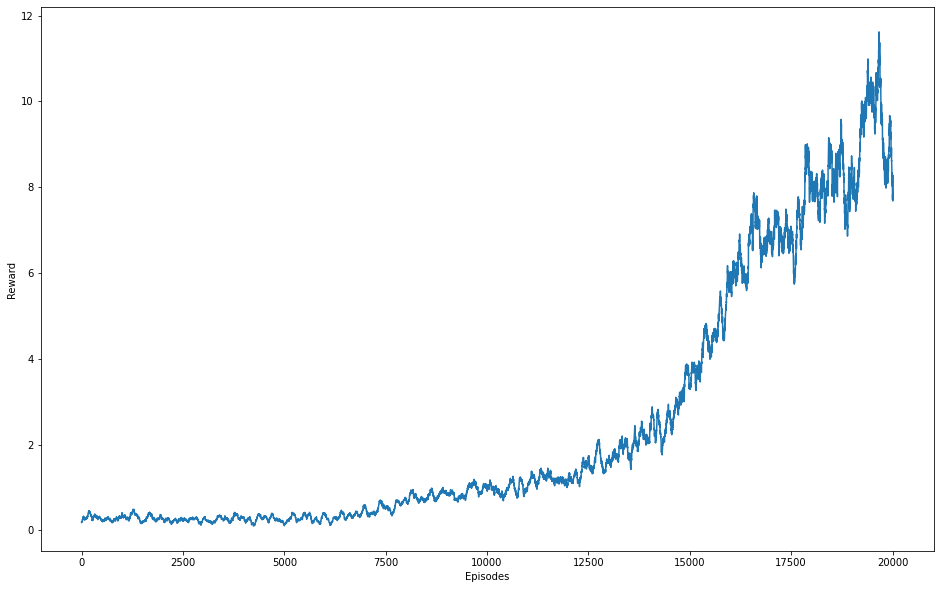

In [10]:
import matplotlib.pyplot as plt

def plot_rewards(episode_reward_history):
    moving_average_rewards = np.convolve(episode_reward_history, np.ones(100) / 100, mode='valid')

    plt.figure(figsize=(16, 10))
    plt.plot(moving_average_rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.show()

print('plotting the rewards...')
episode_reward_history = np.load('/content/drive/MyDrive/game_ai/model/model.npy')
plot_rewards(episode_reward_history)

In [1]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
import numpy as np
rew_hist = np.load('/content/drive/MyDrive/game_ai/model/model.npy')
print(rew_hist.shape)

(20116,)
